# <a id='toc1_'></a>[_CLusters_: búsqueda, _plot_ y PCA](#toc0_)

## <a id='toc1_1_'></a>[General](#toc0_)

In [1]:

import pickle
import os
os.environ['OMP_NUM_THREADS']='1'
import numpy as np
import pandas as pd
from tqdm import tqdm as tqdm
import winsound
import matplotlib.pyplot as plot
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA  
from matplotlib.patches import Circle




C:\anaconda\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
C:\anaconda\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
general_directory=os.getcwd()+'/Data/'

cases=['allt','hw','no','mo']
st=['st','unst']

times=[i*3600 for i in range(0,25)]

times_r=[str(int(times[i]/3600))+'-'+str(int(times[i+1]/3600)) for i in range(len(times)-1)]

with open(general_directory+'Saves/Towers.pkl','r+b') as pk:
        towers=pickle.load(pk)
        
towers_prop=pd.read_csv(general_directory+'/zt_havana_tower.csv')

for i in list(towers_prop['id'].unique()):
    if 99.5>=sum(towers_prop[towers_prop['id']==i]['percent']) or sum(towers_prop[towers_prop['id']==i]['percent'])>=100.5:
        towers_prop.drop(towers_prop[towers_prop['id']==i].index[-1],inplace=True)

zones=pd.read_csv(general_directory+'/transport_zones_properties.csv')

#style
blue='#3498db'
red='#e74c3c'
green='#18bc9c'

plot.rc('font',family='Calibri',size=16)


In [3]:
def save_dataP(name,dictionary,location=general_directory):

    with open(location+'Saves/'+ name+'.pkl', 'wb') as tf:
        pickle.dump(dictionary,tf)
    

### <a id='toc1_2_1_'></a>[Cargar matrices e histogramas](#toc0_)

In [4]:
def load_hist(case,st,days):
    if st=='all': st='unst'
    elif st=='stable':st='st'
        
    with open(general_directory+'Saves/Meanh_'+case+'_'+st+'_'+days+'.pkl','r+b') as pk:
        hist=pickle.load(pk)
    return hist

def load_mat(case,st,days):
    m=np.genfromtxt(general_directory+'Saves/Meanm_'+case+'_'+st+'_'+days+'.csv',delimiter=',')
    return m

def load_mat_z(case,st,days):
    m=np.genfromtxt(general_directory+'Saves/ZMeanm_'+case+'_'+st+'_'+days+'.csv',delimiter=',')
    return m

### <a id='toc1_2_2_'></a>[Torres a zonas](#toc0_)

In [5]:
def matrix_z(matrix_t):
    matrix_z=np.zeros((134,134))
    for i in range(len(towers)):
        for j in range(len(towers)):
            erow=towers_prop[towers_prop['id']==towers[i]]
            ecol=towers_prop[towers_prop['id']==towers[j]]
            for r in range(len(erow['category'])):
                for c in range(len(ecol['category'])):
                    matrix_z[int(erow['category'].iloc[r])-1][int(ecol['category'].iloc[c])-1]+=matrix_t[i][j]*erow['percent'].iloc[r]*ecol['percent'].iloc[c]/10000
    winsound.Beep(30000,500)
    return matrix_z
            
    
def hist_z(hist_t):
    hist_z=pd.DataFrame({i+' In':0 for i in times_r}|{i+' Out':0 for i in times_r},index=range(1,135))
    for i in hist_t.index:
        erow=towers_prop[towers_prop['id']==i]
        for r in range(len(erow['category'])):
                hist_z.loc[int(erow['category'].iloc[r])]+=hist_t.loc[i]*erow['percent'].iloc[r]/100
    return hist_z

### <a id='toc1_2_3_'></a>[Ploteo](#toc0_)

In [6]:
def plots_T(hist,out_or_in,case,st,days,line,comp=False):
        plot.figure() 

        if comp:
                nclus=2
                datos  = hist_z(load_hist('hw','st','week'))
                datos=datos.loc[~(datos==0).all(axis=1)]
                datosrm = datos.div(datos.sum(axis=1), axis=0).fillna(0)  
                clustering = KMeans (n_clusters = nclus,max_iter = 300)
                clustering.fit (datosrm)
                datos['KMeans_clustering'] = clustering.labels_  
                datosrm=pd.concat ([datosrm,datos['KMeans_clustering']],axis=1).dropna()
                if sum(datosrm.loc[1:21].KMeans_clustering)/21<0.5:
                        datosrm.KMeans_clustering=datosrm.KMeans_clustering.apply(lambda x: (1-x))
                c_h=pd.DataFrame([datosrm[datosrm.KMeans_clustering==i].mean() for i in range (nclus)], index=list(range (nclus)))
        if out_or_in=='Inicios':
                hist.loc[0][24:48].plot(kind='line',linestyle=line,label='Casa a trabajo (Periferia)',color=blue)
                hist.loc[1][24:48].plot(kind='line',linestyle=line,label='Casa a trabajo (Centrales)',color=red)
                if comp:
                        c_h.loc[0][24:48].plot(kind='line',linestyle='dashed',label='Casa a trabajo (Periferia)',color=blue)
                        c_h.loc[1][24:48].plot(kind='line',linestyle='dashed',label='Casa a trabajo (Centrales)',color=red)        
                    
        elif out_or_in=='Finales':
                hist.loc[0][:24].plot(kind='line',linestyle=line,label='Casa a trabajo (Periferia)',color=blue)
                hist.loc[1][:24].plot(kind='line',linestyle=line,label='Casa a trabajo (Centrales)',color=red)   
                if comp:
                        c_h.loc[0][:24].plot(kind='line',linestyle='dashed',label='Casa a trabajo (Periferia)',color=blue)
                        c_h.loc[1][:24].plot(kind='line',linestyle='dashed',label='Casa a trabajo (Centrales)',color=red)        
         

        ax = plot.subplot()
        ax.set_xticks(range(24)) 
        ax.set_xticklabels(range(1,25)) 
        plot.legend()
        plot.xlabel('H (h)')
        plot.ylabel('Cantidad de viajes (normalizados)')

        #plot.title(out_or_in+' ('+case+' travels,'+st+' citizens,'+days+'days)')

        #plot.savefig('Data/Images/Clusters '+out_or_in+' ('+case+' travels,'+st+' citizens,'+days+'days).png')
    

In [7]:
def plots_balance(hist,line,maxs=False):
        nclus=2
        mean_hist=pd.DataFrame([hist[hist.KMeans_clustering==i].mean() for i in range (nclus)], index=list(range (nclus))).drop('KMeans_clustering',axis=1)
       
        baOut=mean_hist.transpose()[24:].transpose()
        baIn=mean_hist.transpose()[:24].transpose()

        baOut.columns=[i.replace(' Out','') for i in baOut.columns]
        baIn.columns=[i.replace(' In','') for i in baIn.columns]
                        
        balance_data=baOut-baIn
        labels=['Periféricas','Centrales']
        colors=[blue,red]
        lines=[[1,8.2,15,23],[1,6.5,11.5,17.6]]
        #titles=['periféricas','centrales']
        legends=['upper right','lower right']
        for i in range(2):
                
                plot.figure() 
                plot.axhline(y=0,color='black',linewidth=0.7,alpha=0.7)
                balance_data.loc[i].plot(kind='line',linestyle=line,label=labels[i],color=colors[i],linewidth=2)
                
                if maxs:
                        
                        plot.axvline(x=lines[i][0],color=colors[i],linestyle='dashdot',linewidth=1)
                        plot.axvline(x=lines[i][1],color=colors[i],linestyle='dashdot',linewidth=1)
                        plot.axvline(x=lines[i][2],color=colors[i],linestyle='dashdot',linewidth=1)
                        plot.axvline(x=lines[i][3],color=colors[i],linestyle='dashdot',linewidth=1)
                plot.legend()
                ax = plot.subplot()
                #ax.grid(True,linewidth=0.5,color='gray',alpha=0.5)
                ax.set_xticks(range(24)) 
                ax.set_xticklabels([i if i%2==0 else '' for i in range(1,25) ]) 
                plot.legend(loc=legends[i])
                plot.xlabel('H (h)')
                plot.ylabel('Salidas - Entradas')
                #plot.title('Balance promedio en zonas'+titles[i])

        plot.show()



        #plot.title(out_or_in+' ('+case+' travels,'+st+' citizens,'+days+'days)')

        #plot.savefig('Data/Images/Clusters '+out_or_in+' ('+case+' travels,'+st+' citizens,'+days+'days).png')
    

----
## <a id='toc1_3_'></a>[_Find clusters_](#toc0_)

jambu=plot.figure()
cont=0
for cs in ['allt','mo','no']:
    for s in st:
        for day in ['weekend']:
                    cont+=1

                    datos  = hist_z(load_hist(cs,s,day))
                    datos=datos.loc[~(datos==0).all(axis=1)]
                    datos = datos.div(datos.sum(axis=1), axis=0).fillna(0)
                    
                    wcss = []
                    for i in range (1,11):
                        kmeans  = KMeans (n_clusters = i,max_iter = 300)
                        kmeans.fit (datos)
                        wcss.append (kmeans.inertia_)
                    plot.subplot(2,2,cont)
                    plot.plot (range(1,11),wcss)
                    plot.xlabel ('Número de clusters')
                    plot.ylabel ('wcss')
                    plot.title ('('+cs+', '+s+'able citizens, '+day+'days)')
plot.suptitle('Codo de Jambú',fontweight='bold')
plot.tight_layout()
plot.savefig('Data/Images/Codo de Jambú.jpg')
plot.show()

                    

for cs in ['allt','hw','mo']:
    for s in st:
        for day in ['weekend']:
                if cs =='allt':mat='Todos los viajes'
                elif cs =='hw': mat='Viajes casa trabajo'
                elif cs =='mo':mat='Viajes en la mañana'
                elif cs =='no':mat='Viajes en la tarde'
                if s=='st': estab=' de los ciudadanos estables'
                else: estab=''
                if not all([cs=='hw', s=='unst']):
                    datos  = hist_z(load_hist(cs,s,day))
                    datos=datos.loc[~(datos==0).all(axis=1)]
                    datos = datos.div(datos.sum(axis=1), axis=0).fillna(0)
                    if cs=='hw': estab=''
                    wcss = []
                    for i in range (1,11):
                        kmeans  = KMeans (n_clusters = i,max_iter = 300)
                        kmeans.fit (datos)
                        wcss.append (kmeans.inertia_)
    
                    plot.plot (range(1,11),wcss,label=mat+estab)
                    plot.xlabel ('Número de clusters')
                    plot.ylabel ('wcss')
                    plot.legend()
#plot.savefig('Data/Images/Jambú.jpg')


                    

In [8]:
def clustering(cases,st,days,plot=False,compare=False,line='solid'):

    nclus=2
    datos  = hist_z(load_hist(cases,st,days))
    datos=datos.loc[~(datos==0).all(axis=1)]
    datosrm = datos.div(datos.sum(axis=1), axis=0).fillna(0)
    
    clustering = KMeans (n_clusters = nclus,max_iter = 300)
    clustering.fit (datosrm)
    datos['KMeans_clustering'] = clustering.labels_
    
    datosrm=pd.concat ([datosrm,datos['KMeans_clustering']],axis=1).dropna()
    

    if sum(datosrm.loc[1:21].KMeans_clustering)/21<0.5:
        datosrm.KMeans_clustering=datosrm.KMeans_clustering.apply(lambda x: (1-x))

    c_h=pd.DataFrame([datosrm[datosrm.KMeans_clustering==i].mean() for i in range (nclus)], index=list(range (nclus)))

    if plot== True:
        plots_T(c_h,'Inicios',cases,st,days,line,comp=compare)
        plots_T(c_h,'Finales',cases,st,days,line,comp=compare)

    return datosrm

In [9]:
def pca_anylisis(cases,st,days):
    pca=plot.figure()
    cont=0
    rows=len(cases)
    columns=len(st)*len(days)
    with tqdm(desc="Clusterizing and plotting",total=(len(cases)*len(st)*len(days))) as pbar:
        for cs in cases:
            for s in st:
                for day in days:
                    cont+=1
                    datos=clustering(cs,s,day)
                    ba=datos.drop('KMeans_clustering',axis=1)
                    baOut=ba.transpose()[24:].transpose()
                    baIn=ba.transpose()[:24].transpose()

                    baOut.columns=[i.replace(' Out','') for i in baOut.columns]
                    baIn.columns=[i.replace(' In','') for i in baIn.columns]
                    
                    balance_data=baOut-baIn
                    pca = PCA(n_components = 2)
                    pca_datos = pca.fit_transform (balance_data)
                    pca_datos_df = pd.DataFrame (data = pca_datos, columns = ['Componente_1','Componente_2'] )
                    pca_nombres_datos = pd.concat ([pca_datos_df,datos.reset_index()['KMeans_clustering']],axis=1)
                    
                    plot.subplot(rows,columns,cont)
                    plot.scatter (x = pca_nombres_datos.Componente_1,y=pca_nombres_datos.Componente_2,c=pca_nombres_datos.KMeans_clustering,s=25,cmap='Paired')
                    plot.xlabel ('Componente 1')
                    plot.ylabel ('Componente 2')
                    #plot.title ('('+cs+', '+s+', '+day+')')
                    pbar.update()
                    
    #plot.suptitle('Clusters scatter',fontweight='bold')
    plot.tight_layout()
    plot.savefig('Data/Images/Clusters scatter.jpg')
    plot.show()

  
                   

pca_anylisis(['allt'],['st'],['weekend'])


In [10]:
#allst=clustering('allt','st','week',plot=False,compare=False)
allunst=clustering('allt','unst','week',plot=False,compare=False)
#mounst=clustering('mo','unst','week',plot=False,compare=False)

C:\Users\José Luis\AppData\Local\Temp\ipykernel_12396\3171140696.py:19: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '2.6467675894034564' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  hist_z.loc[int(erow['category'].iloc[r])]+=hist_t.loc[i]*erow['percent'].iloc[r]/100
C:\Users\José Luis\AppData\Local\Temp\ipykernel_12396\3171140696.py:19: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '3.136238307991767' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  hist_z.loc[int(erow['category'].iloc[r])]+=hist_t.loc[i]*erow['percent'].iloc[r]/100
C:\Users\José Luis\AppData\Local\Temp\ipykernel_12396\3171140696.py:19: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '2.19355396

In [ ]:
plots_balance(allst,'solid',maxs=True)

Text(0.5, 1.0, 'Población habanera (%) residente en cada tipo de zona')

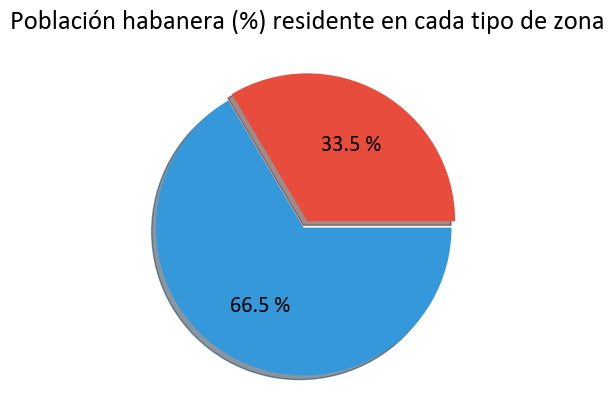

In [40]:
central=allunst[allunst.KMeans_clustering==1].index
peripheral=allunst[allunst.KMeans_clustering==0].index
zones_pop=zones.area_km2*zones.pop_density
pop_central=sum([zones_pop[ind-1] for ind in central])
pop_periph=sum([zones_pop[ind-1] for ind in peripheral])

datos={'Centrales':pop_central,'Periféricas':pop_periph}

plot.pie(datos.values(),colors=[red,blue],autopct='%0.1f %%',
explode=(0,0.05),shadow=True)
plot.title('Población habanera (%) residente en cada tipo de zona')

In [44]:
ba=allunst.drop('KMeans_clustering',axis=1)
baOut=ba.transpose()[24:].transpose()
baIn=ba.transpose()[:24].transpose()

baOut.columns=[i.replace(' Out','') for i in baOut.columns]
baIn.columns=[i.replace(' In','') for i in baIn.columns]
                    
balance_data=baOut-baIn
pca = PCA(n_components = 2)
pca_datos = pca.fit_transform (balance_data)
#pca_datos_df = pd.DataFrame (data = pca_datos, columns = ['Componente_1','Componente_2'] )
#pca_nombres_datos = pd.concat ([pca_datos_df,allunst.reset_index()['KMeans_clustering']],axis=1)
pca_datos_df = pd.DataFrame (data = pca_datos, columns = ['Componente_1','Componente_2'] )
pca_nombres_datos = pd.concat ([pca_datos_df,allunst.reset_index()['KMeans_clustering']],axis=1)

In [52]:
allunst

,0-1 In,1-2 In,2-3 In,3-4 In,4-5 In,5-6 In,6-7 In,7-8 In,8-9 In,9-10 In,...,15-16 Out,16-17 Out,17-18 Out,18-19 Out,19-20 Out,20-21 Out,21-22 Out,22-23 Out,23-24 Out,KMeans_clustering
1,0.004953,0.004060,0.003005,0.002695,0.005437,0.006545,0.011545,0.022426,0.029652,0.026237,...,0.021794,0.024412,0.021849,0.017822,0.015564,0.013564,0.011578,0.009732,0.007230,0
2,0.003940,0.003135,0.002142,0.001822,0.003980,0.005214,0.009954,0.024734,0.039932,0.037181,...,0.029637,0.031770,0.027062,0.020437,0.016419,0.013915,0.011041,0.008833,0.006152,0
3,0.001811,0.001523,0.001158,0.000963,0.002339,0.002986,0.007277,0.038099,0.072290,0.055445,...,0.045045,0.047611,0.036479,0.019203,0.013186,0.009390,0.006144,0.004575,0.002442,1
4,0.003932,0.004460,0.002453,0.002007,0.004343,0.005215,0.014112,0.046023,0.050196,0.034605,...,0.029113,0.035343,0.030013,0.015294,0.013481,0.009247,0.007741,0.005963,0.004096,1
5,0.001672,0.001494,0.000933,0.000627,0.001228,0.001669,0.006606,0.031823,0.070217,0.061552,...,0.046132,0.055564,0.049086,0.026393,0.015218,0.009567,0.006153,0.004120,0.001707,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130,0.002300,0.002428,0.001775,0.001259,0.002390,0.003006,0.007005,0.024323,0.035408,0.030500,...,0.024429,0.026332,0.023535,0.013728,0.011718,0.008867,0.006677,0.004303,0.002286,0
131,0.002467,0.002261,0.001980,0.001227,0.002277,0.002243,0.006739,0.024173,0.027198,0.023599,...,0.020760,0.022782,0.018678,0.012805,0.011158,0.007390,0.005196,0.003355,0.001751,0
132,0.004761,0.003834,0.002925,0.002307,0.004123,0.005779,0.011808,0.030583,0.034901,0.027583,...,0.023872,0.025448,0.022611,0.015734,0.013134,0.010788,0.009127,0.007586,0.005481,0
133,0.003520,0.002766,0.002616,0.001913,0.003192,0.005781,0.019178,0.053501,0.041147,0.030334,...,0.024371,0.029761,0.030039,0.016650,0.013500,0.010260,0.008135,0.005888,0.004241,0


Text(0, 0.5, 'Componente 2')

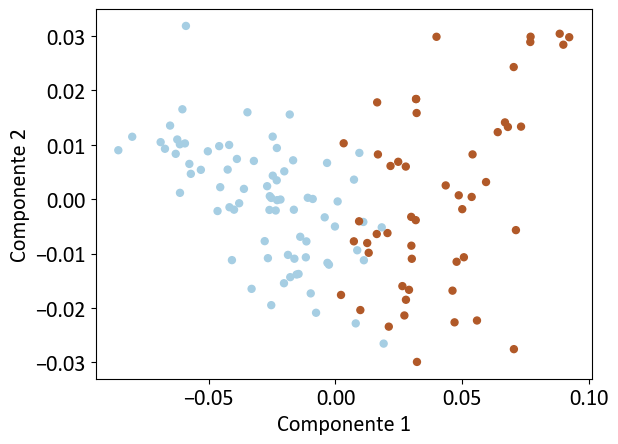

In [49]:
plot.scatter (x = pca_nombres_datos.Componente_1,y=pca_nombres_datos.Componente_2,c=pca_nombres_datos.KMeans_clustering,s=25,cmap='Paired')
plot.xlabel ('Componente 1')
plot.ylabel ('Componente 2')

In [ ]:
pca.explained_variance_ratio_[0]*100+pca.explained_variance_ratio_[1]*100

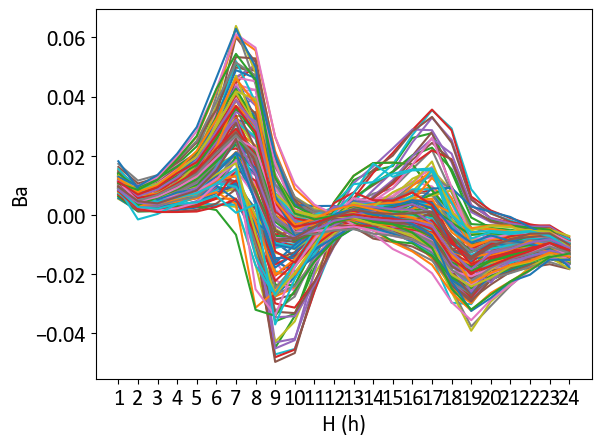

In [42]:
for i in balance_data.index:
    plot.plot(balance_data.loc[i])
ax = plot.subplot()
ax.set_xticks(range(24)) 
ax.set_xticklabels(range(1,25)) 
plot.xlabel('H (h)')
plot.ylabel('Ba')
plot.show()


In [ ]:
plot.plot(pca.components_[0],color=green,label='Componente determinante')
plot.plot(pca.components_[1],color=green,label='Componente reguladora',linestyle='--')
ax = plot.subplot()
ax.set_xticks(range(24)) 
ax.set_xticklabels(range(1,25)) 
plot.xlabel('H (h)')
plot.ylabel('Ba')
plot.legend()
plot.show()

### Tests

pa1=j.drop('KMeans_clustering',axis=1).transpose()[:24].transpose()
pa1.columns=[i.replace(' In','') for i in pa1.columns]
pa2=j.drop('KMeans_clustering',axis=1).transpose()[24:].transpose()
pa2.columns=[i.replace(' Out','') for i in pa2.columns]
pa1 

balance_data=pa2-pa1
pca = PCA(n_components = 2)
pca_datos = pca.fit_transform (balance_data)
pca_datos_df = pd.DataFrame (data = pca_datos, columns = ['Componente_1','Componente_2'] )
pca_nombres_datos = pd.concat ([pca_datos_df,j.reset_index()['KMeans_clustering'],axis=1)
plot.scatter (x = pca_nombres_datos.Componente_1,y=pca_nombres_datos.Componente_2,c=pca_nombres_datos.KMeans_clustering,s=50,cmap='viridis')
plot.show()

----
## <a id='toc1_4_'></a>[_Map_](#toc0_)

In [119]:
import json
import folium
#from shapely.geometry import MultiPoint, Polygon, LineString
from shapely import geometry as shg


In [120]:
def convert_geo_to_shg(features):
    features_shg = []
    shg_props = []
    for i in range(len(features)):
        feature =features[i]
        #print(" working with ",i," ",feature['properties']," \n ============ \n\n ")
        shape = shg.shape(feature['geometry'])
        features_shg.append(shape)
        shg_props.append(feature['properties'])
    return features_shg, shg_props

In [121]:
fd = open('./Data/zonas_de_trasporte.json', 'r')
transp_zones_json = json.load(fd)
fd.close()

transp_zones_shg, transp_props = convert_geo_to_shg(transp_zones_json['features'])

In [122]:
datos=clustering('allt','unst','week')
zones0=list((set(range(134))-set(datos[datos.KMeans_clustering==1].index-1))-set(datos[datos.KMeans_clustering==0].index-1))

C:\Users\José Luis\AppData\Local\Temp\ipykernel_12396\3171140696.py:19: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '2.6467675894034564' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  hist_z.loc[int(erow['category'].iloc[r])]+=hist_t.loc[i]*erow['percent'].iloc[r]/100
C:\Users\José Luis\AppData\Local\Temp\ipykernel_12396\3171140696.py:19: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '3.136238307991767' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  hist_z.loc[int(erow['category'].iloc[r])]+=hist_t.loc[i]*erow['percent'].iloc[r]/100
C:\Users\José Luis\AppData\Local\Temp\ipykernel_12396\3171140696.py:19: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '2.19355396

In [200]:
transp_zones_json0={'type': 'FeatureCollection',
 'name': 'zonas_de_trasporte',
 'crs': {'type': 'name',
  'properties': {'name': 'urn:ogc:def:crs:OGC:1.3:CRS84'}},
 'features':[transp_zones_json['features'][z] for z in zones0]}

transp_zones_json_central_front={'type': 'FeatureCollection',
 'name': 'zonas_de_trasporte',
 'crs': {'type': 'name',
  'properties': {'name': 'urn:ogc:def:crs:OGC:1.3:CRS84'}},
 'features':[transp_zones_json['features'][z] for z in list(datos[datos.KMeans_clustering==1].index-1) if z not in  balance_nucl.keys()]}

transp_zones_json_central_nucl={'type': 'FeatureCollection',
 'name': 'zonas_de_trasporte',
 'crs': {'type': 'name',
  'properties': {'name': 'urn:ogc:def:crs:OGC:1.3:CRS84'}},
 'features':[transp_zones_json['features'][z] for z in list(datos[datos.KMeans_clustering==1].index-1) if z  in  balance_nucl.keys()]}


transp_zones_json_periph_front={'type': 'FeatureCollection',
 'name': 'zonas_de_trasporte',
 'crs': {'type': 'name',
  'properties': {'name': 'urn:ogc:def:crs:OGC:1.3:CRS84'}},
 'features':[transp_zones_json['features'][z] for z in list(datos[datos.KMeans_clustering==0].index-1)if z not in balance_nucl.keys()]}

transp_zones_json_periph_nucl={'type': 'FeatureCollection',
 'name': 'zonas_de_trasporte',
 'crs': {'type': 'name',
  'properties': {'name': 'urn:ogc:def:crs:OGC:1.3:CRS84'}},
 'features':[transp_zones_json['features'][z] for z in list(datos[datos.KMeans_clustering==0].index-1)if z in balance_nucl.keys()]}


### <a id='toc1_4_1_'></a>[Zonas del cluster 0 (azul) vs zonas del cluster 1 (rojo)](#toc0_)

In [201]:
map = folium.Map(location=[23.0826, -82.2845], zoom_start=11, tiles='openstreetmap')

zones_geojson1 = folium.GeoJson(transp_zones_json_periph_front, 
                               style_function = lambda x: {'weight': 1.5, 'fillOpacity' : .1,'color' : blue}, 
                               tooltip=folium.features.GeoJsonTooltip(fields = ['NO_DE_ZONA']))
zones_geojson11 = folium.GeoJson(transp_zones_json_periph_nucl, 
                               style_function = lambda x: {'weight': 1.5, 'fillOpacity' : .4,'color' : blue}, 
                               tooltip=folium.features.GeoJsonTooltip(fields = ['NO_DE_ZONA']))


zones_geojson2 = folium.GeoJson(transp_zones_json_central_front, 
                               style_function = lambda x: {'weight': 1.5, 'fillOpacity' : .1,'color' : red}, 
                               tooltip=folium.features.GeoJsonTooltip(fields = ['NO_DE_ZONA']))
zones_geojson22 = folium.GeoJson(transp_zones_json_central_nucl, 
                               style_function = lambda x: {'weight': 1.5, 'fillOpacity' : .4,'color' : red}, 
                               tooltip=folium.features.GeoJsonTooltip(fields = ['NO_DE_ZONA']))

zones_geojson0 = folium.GeoJson(transp_zones_json0, 
                               style_function = lambda x: {'weight': 1.5, 'fillOpacity' : .1,'color' : 'white'}, 
                               tooltip=folium.features.GeoJsonTooltip(fields = ['NO_DE_ZONA']))
# Para dejar un solo layer cometar aqui

#zones_geojson0.add_to(map)
zones_geojson1.add_to(map)
zones_geojson11.add_to(map)
zones_geojson22.add_to(map)
zones_geojson2.add_to(map)

In [202]:
map

----
## <a id='toc1_4_'></a>[_Graph_](#toc0_)

In [218]:
import networkx as nx
import gravis as gv
from itertools import permutations, combinations

def basic_info(graphs,index):
    connectivity=[]
    radius=[]
    diameter=[]
    periphery=[]
    center=[]

    for G in graphs:
            sc=False
            c=False
            try:
                connectivity.append(nx.is_connected(G))
                if nx.is_connected(G): 
                     c=True


            except:
                connectivity.append(nx.is_strongly_connected(G))
                if nx.is_strongly_connected(G):
                     sc=True
                     
            
            finally:
                if c or sc:
                    radius.append(nx.radius(G))
                    diameter.append(nx.diameter(G))
                    center.append(str(nx.center(G)))
                    periphery.append(str(nx.periphery(G)))
                else:
                    radius.append('∞')
                    diameter.append('∞')
                    center.append('-')
                    periphery.append('-')
    
    info= pd.DataFrame({'Is_connected':connectivity,'Is_weighted':[nx.is_weighted(G) for G in graphs],
               'Assortativity_coefficient': [nx.degree_assortativity_coefficient(G) for G in graphs],
                'Clustering':[nx.average_clustering(G) for G in graphs],
               'Radio': radius, 
               'Diámetro':diameter,
                'Centro':center,
               'Periferia':periphery
        },index=index)


    return info

def nodes_info(graphs,index):

    eccentricity=[]

    for G in graphs:
            sc=False
            c=False
            try:
                if nx.is_connected(G): 
                     c=True
            except:
                if nx.is_strongly_connected(G):
                     sc=True
            finally:
                if c or sc:
                    eccentricity.append(nx.eccentricity(G))

                else:
                    eccentricity.append('-')
    
        
def color_ch(clus_number):
    if clus_number==1:
            color=red
    if clus_number==0:
            color=blue
    return color
#'#3498db'
#'#e74c3c'
def  tooltip(zone_number,df=zones):
    mun=df[df.zone_id==zone_number]['municipio'].loc[zone_number-1]
    return mun
def  population(zone_number,df=zones):
    zones_pop=df.area_km2*df.pop_density
    pop=zones_pop[zone_number-1]
    return pop


datos=clustering('allt','unst','week')
datos.drop([str(i)+'-'+str(i+1)+' In' for i in range(24)],axis=1,inplace=True)
datos.drop([str(i)+'-'+str(i+1)+' Out' for i in range(24)],axis=1,inplace=True)
datos['color']=datos.KMeans_clustering.apply(lambda x:color_ch(x))
datos.drop('KMeans_clustering',axis=1,inplace=True)
datos=datos.reset_index()
datos['hover']=datos['index'].apply(lambda x: tooltip (x))
datos['population']=datos['index'].apply(lambda x: population (x))
datos['zone_number']=datos['index']
datos=datos.set_index('index')
node_attr=datos.to_dict('index')

C:\Users\José Luis\AppData\Local\Temp\ipykernel_12396\3171140696.py:19: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '2.6467675894034564' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  hist_z.loc[int(erow['category'].iloc[r])]+=hist_t.loc[i]*erow['percent'].iloc[r]/100
C:\Users\José Luis\AppData\Local\Temp\ipykernel_12396\3171140696.py:19: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '3.136238307991767' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  hist_z.loc[int(erow['category'].iloc[r])]+=hist_t.loc[i]*erow['percent'].iloc[r]/100
C:\Users\José Luis\AppData\Local\Temp\ipykernel_12396\3171140696.py:19: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '2.19355396

In [215]:
def w_info(graphs,index):
    ex={}
    connectivity=[]
    radius=[]
    diameter=[]
    periphery=[]
    center=[]

    for G in graphs:
            sc=False
            c=False
            try:
                connectivity.append(nx.is_connected(G))
                if nx.is_connected(G): 
                     c=True


            except:
                connectivity.append(nx.is_strongly_connected(G))
                if nx.is_strongly_connected(G):
                     sc=True
                     
            
            finally:

                if c or sc:
                    ex={nodo:max(nx.single_source_dijkstra_path_length(G,nodo,weight='weight').values() )for nodo in G.nodes()}
                    center.append([nodo for nodo,excentricidad in ex.items() if 5*excentricidad/100- min(ex.values())<=excentricidad<=5*excentricidad/100+ min(ex.values())])
                    radius.append(min(ex.values()))
                    diameter.append(max(ex.values()))
                    periphery.append([nodo for nodo,excentricidad in ex.items() if 5*excentricidad/100- max(ex.values())<=excentricidad<=5*excentricidad/100+ max(ex.values())])

                else:
                    radius.append('∞')
                    diameter.append('∞')
                    center.append('-')
                    periphery.append('-')
    
    info= pd.DataFrame({'Is_connected':connectivity,'Is_weighted':[nx.is_weighted(G) for G in graphs],
               'Assortativity_coefficient': [nx.degree_assortativity_coefficient(G) for G in graphs],
                'Clustering':[nx.average_clustering(G) for G in graphs],
               'Radio': radius, 
               'Diámetro':diameter,
                'Centro':center,
               'Periferia':periphery
        },index=index)


    return info

In [216]:
def graph_di(cs,s,days,threshold=500):
    mat=load_mat_z(cs,s,days)
    G = nx.DiGraph()
    
    G.add_weighted_edges_from([(i,j,mat[i-1][j-1]) for i,j in list(permutations(range(1,135),2))+[(i,i) for i in range(1,135)] 
                                   if mat[i-1][j-1]>=threshold])

    #node color by cluster & node tooltip
    nx.set_node_attributes(G,node_attr)
    #node size by degree
    nx.set_node_attributes(G,nx.degree_centrality(G) , 'degree')

    #edge color by connections
    edge_color={}
    for i,j in G.edges():     
            edge_color[(i,j)]=G.nodes[i]['color']  

    nx.set_edge_attributes(G,edge_color,'color')
        
    #nodes positions
    
    for i in G.nodes:
      node= G.nodes[i]
      edges=G.edges()
      contacts=[j for n,j in G.edges() if n==i]+[j for j,n in G.edges() if n==i]
      interconn=sum([1 for n in contacts if node['color']== G.nodes[n]['color']])/len(contacts)
      if node ['color']==red:
          node['x']=250*interconn
      else:
            node['x']=-250*interconn
      node['y']=(node['zone_number']/2)**(3/2)
    return G    



In [217]:
def graph(cs,s,days,threshold=500):
    mat=load_mat_z(cs,s,days)
    G = nx.Graph()
    
    G.add_weighted_edges_from([(i,j,(mat[i-1][j-1]/sum(mat[i-1])-mat[j-1][i-1]/sum(mat[i-1]))) for i,j in list(combinations(range(1,135),2))+[(i,i) for i in range(1,135)] 
                                   if any([mat[i-1][j-1]>=threshold, mat[j-1][i-1]>=threshold ])])

    #node color by cluster & node tooltip
    nx.set_node_attributes(G,node_attr)
    #node size by degree
    nx.set_node_attributes(G,nx.degree_centrality(G) , 'degree')

    #edge color by connections
    edge_color={}
    for i,j in G.edges():     
            edge_color[(i,j)]=G.nodes[i]['color']  

    nx.set_edge_attributes(G,edge_color,'color')
        
    return G    



### Definitions & plots

All travels

In [15]:
G=graph_di('mo','unst','week',threshold=1) 


In [16]:
balance_ex=[]
balance_en=[]
zones_num=[]
colors=[]
for i in G.nodes:
      node= G.nodes[i]
      edges=G.edges()

      contacts_ex=[j for n,j in G.edges() if n==i]
      total_ex=sum([G.edges[(i,j)]['weight'] for j in contacts_ex])
      intraconn_ex=sum([G.edges[(i,j)]['weight']/total_ex for j in contacts_ex if node['color']== G.nodes[j]['color']])
      interconn_ex=sum([G.edges[(i,j)]['weight']/total_ex for j in contacts_ex if node['color']!= G.nodes[j]['color']])
      balance_ex.append(intraconn_ex-interconn_ex)

      contacts_en=[j for j,n in G.edges() if n==i]
      total_en=sum([G.edges[(j,i)]['weight'] for j in contacts_en])
      intraconn_en=sum([G.edges[(j,i)]['weight']/total_en for j in contacts_en if node['color']== G.nodes[j]['color']])
      interconn_en=sum([G.edges[(j,i)]['weight']/total_en for j in contacts_en if node['color']!= G.nodes[j]['color']])
      balance_en.append(intraconn_en-interconn_en)

      zones_num.append(node['zone_number'])
      colors.append(node['color'])

balance=[(balance_ex[i]+balance_en[i])/2 for i in range(len(balance_ex))]

In [198]:
threshold=0
balance_front={zones_num[i]:balance[i] for i in range(len(zones_num)) if balance[i]<=threshold}
colors_front={zones_num[i]:colors[i] for i in range(len(zones_num)) if balance[i]<=threshold}

balance_nucl={zones_num[i]:balance[i]for i in range(len(zones_num)) if balance[i]>threshold}
colors_nucl={zones_num[i]:colors[i] for i in range(len(zones_num)) if balance[i]>threshold}



Text(0, 0.5, 'Pcont(interno)-Pcont(externo)')

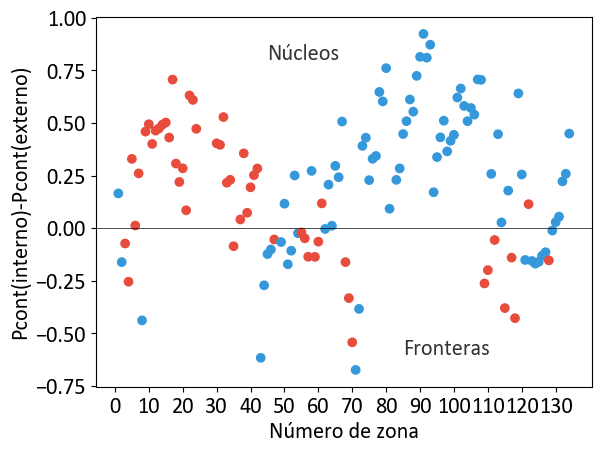

In [214]:
plot.figure() 
plot.axhline(y=0,color='black',linewidth=0.7,alpha=0.7)
#plot.axhline(y=threshold,color=green,linestyle='dashdot',linewidth=0.7,alpha=0.7)

plot.scatter(balance_nucl.keys(),balance_nucl.values(),color=list(colors_nucl.values()))
plot.scatter(balance_front.keys(),balance_front.values(),color=list(colors_front.values()))    
plot.text(45,0.80,'Núcleos',alpha=0.8)
plot.text(85,-0.60,'Fronteras',alpha=0.8)

ax = plot.subplot()
#ax.grid(True,linewidth=0.5,color='gray',alpha=0.5)
ax.set_xticks(range(0,135,10)) 
ax.set_xticklabels([i  for i in range(0,135) if i% 10==0]) 
#plot.title('Balance de probabilidades de contacto')
plot.xlabel('Número de zona') 
plot.ylabel('Pcont(interno)-Pcont(externo)')                               


In [82]:
ba=allunst.drop('KMeans_clustering',axis=1)
baOut=ba.transpose()[24:].transpose()
baIn=ba.transpose()[:24].transpose()

baOut.columns=[i.replace(' Out','') for i in baOut.columns]
baIn.columns=[i.replace(' In','') for i in baIn.columns]
                    
balance_data=baOut-baIn
pca = PCA(n_components = 2)
pca_datos = pca.fit_transform (balance_data)

pca_datos_df = pd.DataFrame (data = pca_datos, columns = ['Componente_1','Componente_2'] ).set_index(allunst.index)
pca_nombres_datos = pd.concat ([pca_datos_df,allunst['KMeans_clustering']],axis=1)

Text(0, 0.5, 'Pcont(interno)-Pcont(externo)')

<Figure size 640x480 with 0 Axes>

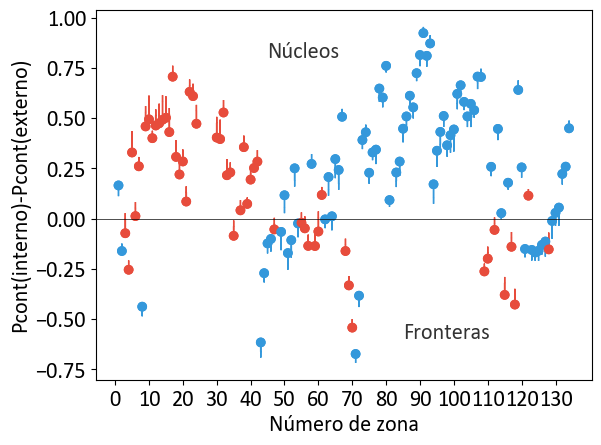

In [221]:
plot.figure() 
plot.figure() 
plot.axhline(y=0,color='black',linewidth=0.7,alpha=0.7)
#plot.axhline(y=threshold,color=green,linestyle='dashdot',linewidth=0.7,alpha=0.7)

plot.scatter(balance_nucl.keys(),balance_nucl.values(),color=list(colors_nucl.values()))
plot.scatter(balance_front.keys(),balance_front.values(),color=list(colors_front.values()))    
plot.text(45,0.80,'Núcleos',alpha=0.8)
plot.text(85,-0.60,'Fronteras',alpha=0.8)
c=0
for i in G.nodes():
    plot.arrow(i,balance[c],0,pca_nombres_datos.loc[i].Componente_1,width=0.1,head_width=0.02,color=colors[c])
    c+=1

plot.scatter(zones_num,balance,color=colors)    
ax = plot.subplot()
#ax.grid(True,linewidth=0.5,color='gray',alpha=0.5)
ax.set_xticks(range(0,135,10)) 
ax.set_xticklabels([i  for i in range(0,135) if i% 10==0]) 
#plot.title('Balance de probabilidades de contacto')
plot.xlabel('Número de zona') 
plot.ylabel('Pcont(interno)-Pcont(externo)')      

In [219]:
new_data=datos[:]
new_colors=balance_front.keys()
for i in new_colors:
    new_data.loc[new_data.index==i,'color']=green

Text(0, 0.5, 'Componente 2')

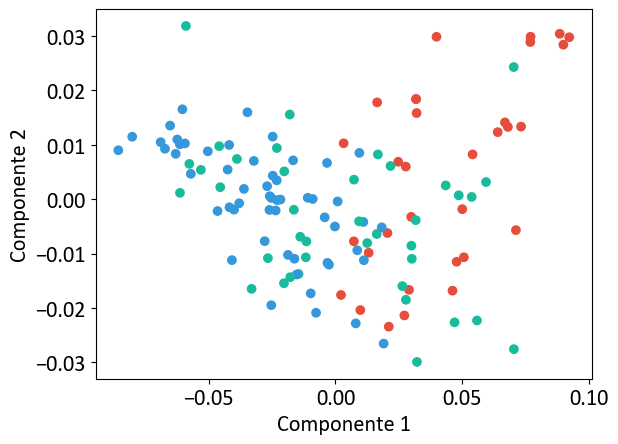

In [220]:
plot.scatter (x = pca_nombres_datos.Componente_1,y=pca_nombres_datos.Componente_2,color=new_data.color)
plot.xlabel ('Componente 1')
plot.ylabel ('Componente 2')

In [ ]:
G_mo=graph_di('allt','unst','week',threshold=10) 

Morning travels 

In [ ]:
G_mo=graph_di('allt','unst','week',threshold=10) 

In [ ]:
nx.write_graphml(G_mo,'nx.html')
gv.d3(G_mo,show_node_label=False,use_edge_size_normalization=True,use_node_size_normalization=True,node_size_data_source='population',node_hover_neighborhood=True,edge_size_normalization_min=0.1,node_size_normalization_max=30,edge_curvature=0.3,edge_size_data_source='weight')

Afternoon travels

nx.write_graphml(G_no,'nx.html')
gv.d3(G_no,use_edge_size_normalization=True,use_node_size_normalization=True,node_hover_neighborhood=True,node_size_data_source='degree',node_size_normalization_min=10,edge_curvature=0.3,edge_size_data_source='weight')

### Info 

In [ ]:
gv.d3(G.subgraph(s_C[4:]),graph_height=900,use_edge_size_normalization=True,use_node_size_normalization=True,node_size_data_source='betweenness',node_hover_neighborhood=True,node_size_normalization_min=10,edge_curvature=0.3,edge_size_data_source='weight',use_centering_force=True,links_force_strength=0.2,edge_size_factor=0.5)                        

In [ ]:
ex={nodo:max(nx.single_source_dijkstra_path_length(G_sc_sw,nodo,weight='weight').values() )for nodo in G_sc_sw.nodes()}
ex.items()

centro=[nodo for nodo,excentricidad in ex.items() if 5*excentricidad/100- min(ex.values())<=excentricidad<=5*excentricidad/100+ min(ex.values())]
centro

In [ ]:
ex={nodo:max(nx.single_source_dijkstra_path_length(G.subgraph(s_C[4:]),nodo,weight='weight').values() )for nodo in G.subgraph(s_C[4:]).nodes()}
ex.items()
centro=[nodo for nodo,excentricidad in ex.items() if 5*excentricidad/100- min(ex.values())<=excentricidad<=5*excentricidad/100+ min(ex.values())]
centro

In [ ]:
gv.d3(G.subgraph(s_C[4:]).subgraph(list(nx.center(G.subgraph(s_C[4:])))),graph_height=900,use_edge_size_normalization=True,use_node_size_normalization=True,node_size_data_source='betweenness',node_hover_neighborhood=True,node_size_normalization_min=10,edge_curvature=0.3,edge_size_data_source='weight',use_centering_force=True,links_force_strength=0.2,edge_size_factor=1)                        

In [ ]:
gv.d3(G_sc_sw.subgraph(list(centro)),graph_height=900,use_edge_size_normalization=True,use_node_size_normalization=True,node_size_data_source='betweenness',node_hover_neighborhood=True,node_size_normalization_min=10,edge_curvature=0.3,edge_size_data_source='weight',use_centering_force=True,links_force_strength=0.2,edge_size_factor=1)                        

In [ ]:
gv.d3(G_sc.subgraph(list(nx.periphery(G_sc))),use_edge_size_normalization=True,use_node_size_normalization=True,node_size_data_source='betweenness',node_hover_neighborhood=True,node_size_normalization_min=10,edge_curvature=0.3,edge_size_data_source='weight')


In [ ]:
for i in [21,22,23,37]:
    if i in G_sco.nodes: print(i)

In [ ]:
for i in nx.center(G_sc):
    if i in G_sco.nodes: print(i)

Adjacency matrix

In [ ]:
A_mat = np.zeros([134,134]) + nx.adjacency_matrix(G) #all
A_mat_mo = np.zeros([134,134]) + nx.adjacency_matrix(G_mo) #morning
A_mat_no = np.zeros([134,134]) + nx.adjacency_matrix(G_no) #noon

Degree histograms    

In [ ]:

plot.figure()  

plot.hist(nx.degree_histogram(G),color=blue)  
ax = plot.subplot()
ax.set_xticks(range(max(nx.degree_histogram(G))+1)) 
ax.set_xticklabels(range(max(nx.degree_histogram(G))+1)) 

plot.title('Degree histogram (all)')

    
plot.show()


In [ ]:

plot.figure()  

plot.hist(nx.degree_histogram(G_mo),color=blue)  
ax = plot.subplot()
ax.set_xticks(range(max(nx.degree_histogram(G_mo))+1)) 
ax.set_xticklabels(range(max(nx.degree_histogram(G_mo))+1)) 

plot.title('Degree histogram (mo)')

    
plot.show()


Degree histogram by cluster

In [ ]:
nodes_0=[]
for node in dict(list(G.degree)).keys():
    if node in datos.index:
        if datos.loc[node]['color']==blue: 
            nodes_0.append(node)
nodes_1=[]
for node in dict(list(G.degree)).keys():
    if node in datos.index:
        if datos.loc[node]['color']==red: 
            nodes_1.append(node)
        
nodes_0mo=[]
for node in dict(list(G_mo.degree)).keys():
    if node in datos.index:
        if datos.loc[node]['color']==blue: 
            nodes_0mo.append(node)
nodes_1mo=[]
for node in dict(list(G_mo.degree)).keys():
    if node in datos.index:
        if datos.loc[node]['color']==red: 
            nodes_1mo.append(node)

In [ ]:
fig=plot.figure()

plot.subplot(2,2,1)
plot.hist(nodes_0,weights=[dict(list(G.degree))[node] for node in nodes_0],bins=len(nodes_0),color=blue,range=(0,len(nodes_0)+1))                
plot.xlabel ('Nodes')
plot.ylabel ('Degree')
plot.title ('Cluster 0 (all)')



plot.subplot(2,2,2)
plot.hist(nodes_1,weights=[dict(list(G.degree))[node] for node in nodes_1],bins=len(nodes_1),color=red,range=(0,len(nodes_1)+1))                
plot.xlabel ('Nodes')
plot.ylabel ('Degree')
plot.title ('Cluster 1 (all)')

plot.subplot(2,2,3)
plot.hist(nodes_0mo,weights=[dict(list(G_mo.degree))[node] for node in nodes_0mo],bins=len(nodes_0mo),color=blue,range=(0,len(nodes_0mo)+1))                
plot.xlabel ('Nodes')
plot.ylabel ('Degree')
plot.title ('Cluster 0 (mo)')



plot.subplot(2,2,4)
plot.hist(nodes_1mo,weights=[dict(list(G_mo.degree))[node] for node in nodes_1mo],bins=len(nodes_1mo),color=red,range=(0,len(nodes_1mo)+1))                
plot.xlabel ('Nodes')
plot.ylabel ('Degree')
plot.title ('Cluster 1 (mo)')


plot.suptitle('Node Vs degree',fontweight='bold')
plot.tight_layout()

    
plot.show()


## SIS trought graph

In [ ]:
def graph_undi(cs,s,days,threshold=4):
    mat=load_mat_z(cs,s,days)
    G = nx.DiGraph()

    G.add_weighted_edges_from([(i,j,((mat[i-1][j-1]/sum(mat[i-1]))+(mat[j-1][i-1]/sum(mat[j-1])))*1/2) for i,j in list(combinations(range(1,135),2))+[(i,i) for i in range(1,135)] 
                                   if any([100*mat[i-1][j-1]/sum(mat[i-1])>=threshold,100*mat[j-1][i-1]/sum(mat[j-1])>=threshold])])

    #node color by cluster & node tooltip
    nx.set_node_attributes(G,node_attr)
    #node size by betweenness
  
    nx.set_node_attributes(G,nx.betweenness_centrality(G) , 'betweenness')
    #node size by degree
    nx.set_node_attributes(G,nx.degree_centrality(G) , 'degree')

    #edge color by connections
    edge_color={}
    for i,j in G.edges():
        
            if  G.nodes[i]['color']==G.nodes[j]['color']: 
                edge_color[(i,j)]=G.nodes[i]['color']  
            else: 
                edge_color[(i,j)]='black'  

    nx.set_edge_attributes(G,edge_color,'color')
  
    return G    



In [ ]:
G=graph_undi('allt','unst','week',threshold=0.0000001)

In [ ]:
nx.draw(G,node_size=0.1)

In [ ]:
import EoN
# Define the epidemic parameters
β = 0.01  # Infection rate
μ = 0.01  # Recovery rate
N =G.number_of_nodes()
# Define the initial condition
I0 = set([1])

# Simulate the epidemic process with a fractiom rho infected at time 0
#t, S, I, R = EoN.fast_SIR(G, β, μ, rho=0.1)

# Simulate the epidemic process starting from nodes in I0 infecteds
t, S, I, R = EoN.fast_SIR(G, β, μ, initial_infecteds=I0)

In [ ]:
# Plot the results
import matplotlib.pyplot as plt
plt.plot(t, S/N, label='Susceptible',color=green)
plt.plot(t, I/N, label='Infected',color=red)
plt.plot(t, R/N, label='Recovered',color=blue)

plt.legend()
plt.show()

In [ ]:
# full data gives you the state of each node in time
sim = EoN.fast_SIR(G, β, μ, initial_infecteds=I0, return_full_data=True) 

In [ ]:
options={'nodeColor':green, 'infectedColor':red,'recoveredColor':blue}
ani=sim.animate(ts_plots=['I', 'SIS'], node_size = 5)
ani.save('SIS_Habana.gif', fps=5)
wind